In [1]:
import numpy as np
import keras
import keras.backend as k
from keras.layers import Conv2D,MaxPooling2D,SpatialDropout2D,Flatten,Dropout,Dense
from keras.models import Sequential,load_model
from keras.optimizers import Adam
from keras.preprocessing import image
import cv2
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D() )
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
        '/Users/dakshkhanna/Downloads/dataset/train/',
        target_size=(150,150),
        batch_size=16 ,
        class_mode='binary')

test_set = test_datagen.flow_from_directory(
        '/Users/dakshkhanna/Downloads/dataset/test/',
        target_size=(150,150),
        batch_size=16,
        class_mode='binary')

model_saved=model.fit_generator(
        training_set,
        epochs=10,
        validation_data=test_set,

        )

model.save('mymodel.h5',model_saved)

Found 1315 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


<ipython-input-5-8bc525207fda>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_saved=model.fit_generator(


Epoch 1/10
36/83 [============>.................] - ETA: 16s - loss: 0.6840 - accuracy: 0.5648

/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2942: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


UnknownError: Graph execution error:

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fae97a9fbd0>
Traceback (most recent call last):

  File "/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1030, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/data_adapter.py", line 831, in wrapped_generator
    for data in generator_fn():

  File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/data_adapter.py", line 957, in generator_fn
    yield x[i]

  File "/opt/anaconda3/lib/python3.8/site-packages/keras/preprocessing/image.py", line 110, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/opt/anaconda3/lib/python3.8/site-packages/keras/preprocessing/image.py", line 337, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/image_utils.py", line 394, in load_img
    img = pil_image.open(io.BytesIO(f.read()))

  File "/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py", line 2943, in open
    raise UnidentifiedImageError(

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7fae97a9fbd0>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_1419]

In [14]:
loss_val = model_saved.history['val_loss']
loss_val

[0.1558080017566681,
 0.1728304773569107,
 0.08935420215129852,
 0.07037076354026794,
 0.07477103918790817,
 0.08565379679203033,
 0.11913090944290161,
 0.07875034213066101,
 0.06470435112714767,
 0.0962849035859108]

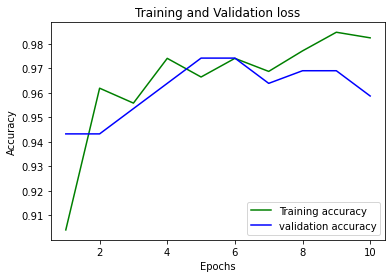

In [20]:
loss_train = model_saved.history['accuracy']
loss_val = model_saved.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
#To test for individual images

mymodel=load_model('mymodel.h5')
test_image=tf.keras.utils.load_img(r'Downloads/FaceMaskDetector-master/test/with_mask/1-with-mask.jpg',
                          target_size=(150,150,3))
test_image
test_image=tf.keras.preprocessing.image.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
mymodel.predict(test_image)[0][0]

# IMPLEMENTING LIVE DETECTION OF FACE MASK

mymodel=load_model('mymodel.h5')

cap=cv2.VideoCapture(0)
face_cascade=cv2.CascadeClassifier('Downloads/FaceMaskDetector-master/haarcascade_frontalface_default.xml')

while cap.isOpened():
    _,img=cap.read()
    face=face_cascade.detectMultiScale(img,scaleFactor=1.1,minNeighbors=4)
    for(x,y,w,h) in face:
        face_img = img[y:y+h, x:x+w]
        cv2.imwrite('temp.jpg',face_img)
        test_image=tf.keras.utils.load_img('temp.jpg',target_size=(150,150,3))
        test_image=tf.keras.preprocessing.image.img_to_array(test_image)
        test_image=np.expand_dims(test_image,axis=0)
        pred=mymodel.predict(test_image)[0][0]
        if pred==1:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),3)
            cv2.putText(img,'Not Wearing Mask',((x+w)//2,y+h+20),cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1,(0,0,255),3)
        else:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),3)
            cv2.putText(img,'Wearing Mask',((x+w)//2,y+h+20),cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1,(0,255,0),3)
        datet=str(datetime.datetime.now())
        cv2.putText(img,datet,(400,450),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),1)
          
    cv2.imshow('img',img)
    
    if cv2.waitKey(1)==ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()
